In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as T
from tqdm import tqdm
%load_ext autoreload
%autoreload 2
from utils import greed_assignment,LAP
from plot_utils import plot_3d
from model import Siren,AssignmentModel
from data_model import traveling_time_dataset_fix_wavespeed
from sgld import SGLD
from ot.lp import wasserstein_1d
import matplotlib.pyplot as plt
import copy
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')


In [70]:
grid_size=64
vmin=0.5
vmax=2.5
n_station=20

## Generate dataset

In [71]:
image_nx = 2301
image_nz = 751
dx = 4.0
v = torch.from_file('Marmousi.bin', size=image_nx*image_nz).reshape(image_nx, image_nz).T
v=v/v.max()
vPIL=torchvision.transforms.ToPILImage()(v)
v_imgs = T.Resize(size=[grid_size,grid_size])(vPIL)
v_imgs=torchvision.transforms.ToTensor()(v_imgs)[0]
V=v_imgs.repeat(grid_size,1,1).permute(0,2,1) #to 3D
V=V.numpy()
V=(V-V.min())/(V.max()-V.min())
V=V*(vmax-vmin)+vmin
ttdata=traveling_time_dataset_fix_wavespeed(V,n_station,grid_size)

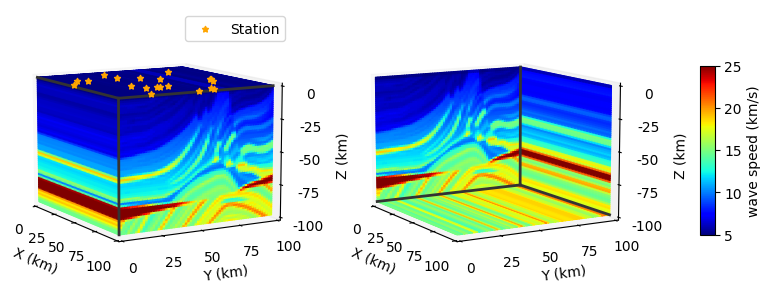

In [72]:
[fig,ax0,ax1]=plot_3d(V)
coord=ttdata.loc_src_index
ax0.scatter3D(coord[:,0],coord[:,1],coord[:,2],s=20,depthshade=0,zorder=1e20,marker=(5, 1),color='orange',label='Station')
_=ax0.legend()

## Fit traveling time 

In [74]:
batch_size_siren=512
first_omega_0=15
hidden_omega_0=15
model_traveltime= Siren(in_features=3, out_features=n_station, hidden_features=512, 
                        hidden_layers=4, outermost_linear=True,first_omega_0=first_omega_0, hidden_omega_0=hidden_omega_0).to(device)
optimizer = torch.optim.Adam(model_traveltime.parameters(), lr=0.00001)
loss_function=torch.nn.MSELoss(reduction='mean')
train_loader = torch.utils.data.DataLoader(ttdata, batch_size=batch_size_siren, shuffle=True,num_workers=8)

In [75]:
for epoch in range(100):
    model_traveltime.train()
    loss_batch = 0
    for data in train_loader:
        X = data['in'].float().to(device)
        Y = data['out'].float().to(device)
        Ypred,_= model_traveltime(X)
        loss = loss_function(Y, Ypred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_batch += loss.item()

    loss_epoch = loss_batch/len(train_loader)
    print(f'Epoch: {epoch:03d}, Train Loss: {loss_epoch:.2E}')
    if loss_epoch<1e-5:
        break

Epoch: 000, Train Loss: 6.51E-02
Epoch: 001, Train Loss: 2.04E-03
Epoch: 002, Train Loss: 6.85E-04
Epoch: 003, Train Loss: 2.99E-04
Epoch: 004, Train Loss: 1.57E-04
Epoch: 005, Train Loss: 9.52E-05
Epoch: 006, Train Loss: 6.57E-05
Epoch: 007, Train Loss: 4.98E-05
Epoch: 008, Train Loss: 4.07E-05
Epoch: 009, Train Loss: 3.47E-05
Epoch: 010, Train Loss: 2.93E-05
Epoch: 011, Train Loss: 2.67E-05
Epoch: 012, Train Loss: 2.43E-05
Epoch: 013, Train Loss: 2.21E-05
Epoch: 014, Train Loss: 2.04E-05
Epoch: 015, Train Loss: 1.94E-05
Epoch: 016, Train Loss: 1.85E-05
Epoch: 017, Train Loss: 1.70E-05
Epoch: 018, Train Loss: 1.66E-05
Epoch: 019, Train Loss: 1.60E-05
Epoch: 020, Train Loss: 1.52E-05
Epoch: 021, Train Loss: 1.46E-05
Epoch: 022, Train Loss: 1.38E-05
Epoch: 023, Train Loss: 1.33E-05
Epoch: 024, Train Loss: 1.29E-05
Epoch: 025, Train Loss: 1.23E-05
Epoch: 026, Train Loss: 1.15E-05
Epoch: 027, Train Loss: 1.21E-05
Epoch: 028, Train Loss: 1.13E-05
Epoch: 029, Train Loss: 1.10E-05
Epoch: 030

## Generate earthquake dataset

In [349]:
n_earthquake=8
tau_max=1 #1=10s
loc_earthquake_index=np.random.randint(grid_size,size=[n_earthquake,3])
tt=ttdata.travel_time.reshape(n_station,grid_size,grid_size,grid_size)
true_receiver= tt[:,loc_earthquake_index[:,0],loc_earthquake_index[:,1],loc_earthquake_index[:,2]]
loc_earthquake_coord=loc_earthquake_index/(grid_size-1)
time_earthquake = np.random.rand(n_earthquake)*tau_max

## received signal is sorted
true_station_travelingtime=np.zeros_like(true_receiver)
true_station_travelingtime_index=np.zeros_like(true_receiver,dtype=int)
for i in range(n_station):
    true_receiver[i,:]=true_receiver[i,:]+time_earthquake
    true_station_travelingtime[i,:]=np.sort(true_receiver[i,:])
    true_station_travelingtime_index[i,:]=np.argsort(true_receiver[i,:])

## Init our model

In [351]:
for try_i in range(1000): # usually need 1~5 trials 
    loc_record_list=[]
    lowest_loss=100000
    updata_lr_flag=True    
    L=0 #dimention of the wave speed, for fixed wave speed, L=0
    batch_size=100
    model_traveltime_=copy.deepcopy(model_traveltime).to(device)
    AModel=AssignmentModel(model_traveltime_, n_station, n_earthquake,tau_max,L=L).to(device)
    optimizer = SGLD(AModel.parameters(), lr=0.01,noise=1e-3)
    loc_earthquake_re=AModel.loc_earthquake.detach().clone().cpu().numpy()
    loc_record_list.append(loc_earthquake_re)
    for epoch in range(30):
        loss_batch = 0
        count=0
        for count in range(batch_size):
            i=np.random.randint(n_station) ## update one station at each time 
            out=AModel().T
            outi=out[i,:]
            Y=torch.tensor(true_station_travelingtime[i,:]).float().to(device)
            loss = wasserstein_1d(outi, Y, p=2)
            loss_batch += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_epoch = loss_batch/batch_size
        
        ## change hp
        if loss_epoch<0.001 and updata_lr_flag:
            updata_lr_flag=False
            optimizer = SGLD(AModel.parameters(), lr=0.001,noise=1e-4)            
        
        ## val test
        loc_earthquake_re=AModel.loc_earthquake.detach().clone().cpu().numpy()
        loc_record_list.append(loc_earthquake_re)
        indexB=greed_assignment(loc_earthquake_coord,loc_earthquake_re)  # only check the test perfermance roughly
        loc_error=((loc_earthquake_coord[indexB,:]-loc_earthquake_re)**2).mean()
        time_earthquake_re=AModel.time_earthquake.detach().clone().cpu().numpy()
        time_error=(((time_earthquake[indexB]-time_earthquake_re)/tau_max)**2).mean()
        if loss_epoch <lowest_loss:
            lowest_loss= loss_epoch
            lowest_loss_loc_earthquake_re = loc_earthquake_re
            lowest_loss_time_earthquake_re = time_earthquake_re
            lowest_loss_out = AModel(sort_out=False).clone().detach().cpu().numpy().T
        
        print(f'Try: {try_i:03d},Epoch: {epoch:03d}, Loss: {loss_epoch:.6f}, Loc error: {loc_error:.6f}, Time error: {time_error:.6f}')
    if lowest_loss<0.0001:
            break

## training with a small learning rate to get a better reconstruction.
optimizer = SGLD(AModel.parameters(), lr=0.0001,noise=1e-5)            
for epoch in range(50):
    loss_batch = 0
    count=0
    for count in range(batch_size):
        i=np.random.randint(n_station) ## update one station at each time 
        out=AModel().T
        outi=out[i,:]
        Y=torch.tensor(true_station_travelingtime[i,:]).float().to(device)
        loss = wasserstein_1d(outi, Y, p=2)
        loss_batch += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_epoch = loss_batch/batch_size
    
    ## val test
    loc_earthquake_re=AModel.loc_earthquake.detach().clone().cpu().numpy()
    loc_record_list.append(loc_earthquake_re)
    indexB=greed_assignment(loc_earthquake_coord,loc_earthquake_re)  # only check the test perfermance roughly
    loc_error=((loc_earthquake_coord[indexB,:]-loc_earthquake_re)**2).mean()
    time_earthquake_re=AModel.time_earthquake.detach().clone().cpu().numpy()
    time_error=(((time_earthquake[indexB]-time_earthquake_re))**2).mean()
    if loss_epoch <lowest_loss:
        lowest_loss= loss_epoch
        lowest_loss_loc_earthquake_re = loc_earthquake_re
        lowest_loss_time_earthquake_re = time_earthquake_re
        lowest_loss_out = AModel(sort_out=False).clone().detach().cpu().numpy().T
    print(f'Try: {try_i:03d},Epoch: {epoch:03d}, Loss: {loss_epoch:.6f}, Loc error: {loc_error:.6f}, Time error: {time_error:.6f}')

Try: 000,Epoch: 000, Loss: 0.006251, Loc error: 0.094520, Time error: 0.032576
Try: 000,Epoch: 001, Loss: 0.002348, Loc error: 0.060885, Time error: 0.051816
Try: 000,Epoch: 002, Loss: 0.001861, Loc error: 0.049097, Time error: 0.039969
Try: 000,Epoch: 003, Loss: 0.001513, Loc error: 0.080006, Time error: 0.014558
Try: 000,Epoch: 004, Loss: 0.001291, Loc error: 0.038837, Time error: 0.008129
Try: 000,Epoch: 005, Loss: 0.001198, Loc error: 0.073873, Time error: 0.013007
Try: 000,Epoch: 006, Loss: 0.001221, Loc error: 0.024280, Time error: 0.017741
Try: 000,Epoch: 007, Loss: 0.000621, Loc error: 0.025326, Time error: 0.017009
Try: 000,Epoch: 008, Loss: 0.000317, Loc error: 0.023404, Time error: 0.018092
Try: 000,Epoch: 009, Loss: 0.000238, Loc error: 0.022974, Time error: 0.018101
Try: 000,Epoch: 010, Loss: 0.000256, Loc error: 0.016957, Time error: 0.013708
Try: 000,Epoch: 011, Loss: 0.000253, Loc error: 0.015886, Time error: 0.013634
Try: 000,Epoch: 012, Loss: 0.000232, Loc error: 0.01

Accuracy: 0.9625


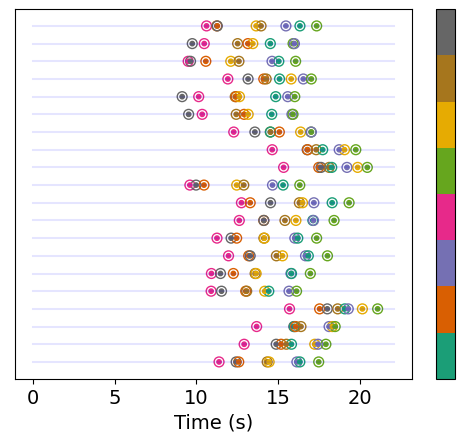

In [352]:
from scipy.optimize import quadratic_assignment
from scipy.spatial import distance_matrix

assignment_function=greed_assignment

plt.rcParams.update({'font.size': 14})
indexB=assignment_function(loc_earthquake_coord,loc_earthquake_re)  #to get a order
plt.figure(figsize=(6.4, 4.8))
Crange=range(n_earthquake)
xaxis_max=lowest_loss_out.max()*1.1
cmap = plt.cm.get_cmap('Dark2', n_earthquake)
correct_rate=0
for i in range(n_station):
    yaxis_i=np.ones(n_earthquake)*i
    tx=true_station_travelingtime[i,]
    ti=true_station_travelingtime_index[i,:]
    out=lowest_loss_out[i,:]
    indexBi=assignment_function(out.reshape(-1,1),tx.reshape(-1,1))
    plt.plot([0,xaxis_max*9.5],[i,i],'-b',alpha=0.1)
    plt.scatter(tx*10,yaxis_i,marker='o', facecolors='none',s=50,alpha=1,edgecolors=cmap(ti[Crange]))
    plt.scatter(tx*10,yaxis_i,cmap=cmap,c=indexB[indexBi[Crange]],s=10,alpha=1)
    correct_rate+=np.mean(ti[Crange]==indexB[indexBi[Crange]])
cbar=plt.colorbar()
plt.xlabel('Time (s)')
plt.yticks([])
cbar.ax.tick_params(length=0)
cbar.set_ticks([])
print('Accuracy:',correct_rate/n_station)

# Plot trajectory

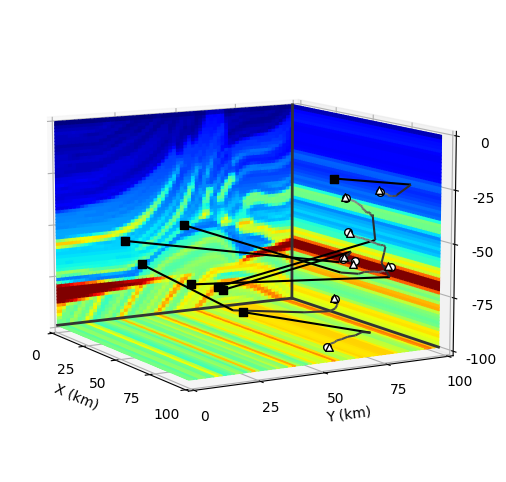

In [353]:
import matplotlib as mpl
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.cm import ScalarMappable
plt.rcParams.update({'font.size': 10})
cmap=plt.cm.jet
bar_label='Wave speed (km/s)'
zoom_scale=1
nx,ny,nz=grid_size,grid_size,grid_size

X, Y, Z = np.meshgrid(np.arange(nx), np.arange(ny), -np.arange(nz))
data = np.transpose(V,[1,0,2])*10
#data=np.array(c)
kw = {
    'vmin': 5,
    'vmax': 25,
}
norm = mpl.colors.Normalize(**kw)
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111, projection='3d',computed_zorder=False)
# Plot contour surfaces
ax1.plot_surface(
    X[:, :, -1], Y[:, :, -1], Z[:,:,-1],rstride=1, cstride=1, facecolors=cmap(norm(data[:, :, -1])),shade=False)
ax1.plot_surface(
    X[-1, :, :], Y[-1, :, :], Z[-1,:,:],rstride=1, cstride=1, facecolors=cmap(norm(data[-1, :, :])),shade=False)
ax1.plot_surface(
    X[:, 0, :], Y[:, 0, :], Z[:,0,:],rstride=1, cstride=1, facecolors=cmap(norm(data[:, 0, :])),shade=False)


xmin, xmax = X.min(), X.max()
ymin, ymax = Y.min(), Y.max()
zmin, zmax = Z.min(), Z.max()
ax1.set(xlim=[xmin, xmax], ylim=[ymin, ymax], zlim=[zmin, zmax])



# Plot edges
edges_kw = dict(color='0.2', linewidth=2, zorder=1e2)
ax1.plot([xmin, xmin], [ymin, ymax], [zmin,zmin], **edges_kw)
ax1.plot([xmin, xmax], [ymax, ymax], [zmin,zmin], **edges_kw)
ax1.plot([xmin, xmin], [ymax, ymax], [zmin, zmax], **edges_kw)



# Set labels and zticks
ax1.set(
    xlabel='X (km)',
    ylabel='Y (km)',
    zlabel='Z (km)',
    zticks=[0,-int(nz/4),-int(nz/4*2),-int(nz/4*3),-nz],
    zticklabels=[0,-25, -50,-75,-100],
    xticks=[0,int(nx/4),int(nx/4*2),int(nx/4*3),nx],
    xticklabels=[0, 25,50,75,100],
    yticks=[0,int(nx/4),int(ny/4*2),int(ny/4*3),ny],
    yticklabels=[0, 25,50,75,100],
)

ax1.view_init(10, -30, 0)
ax1.set_box_aspect(None, zoom=1)




#sc=ax1.scatter3D(trj[:,0]*(grid_size-1),trj[:,1]*(grid_size-1),-trj[:,2]*(grid_size-1),s=20,depthshade=0,zorder=1e20,cmap='binary',c=range(trj.shape[0]),edgecolors='black')

init_re=loc_record_list[0]
ax1.scatter(init_re[:,0]*(grid_size-1),init_re[:,1]*(grid_size-1),-init_re[:,2]*(grid_size-1),s=30,color='black',marker='s',label='Earthquake',depthshade=0,edgecolors='black',zorder=1e11)
ax1.scatter(loc_earthquake_re[:,0]*(grid_size-1),loc_earthquake_re[:,1]*(grid_size-1),-loc_earthquake_re[:,2]*(grid_size-1),s=30,color='white',marker='o',label='Earthquake',depthshade=0,edgecolors='black',zorder=1e21)
cmap = plt.cm.get_cmap('gray')
loc_np=np.array(loc_record_list)

kw = {
    'vmin': 0,
    'vmax': loc_np.shape[0]**0.4,
}
norm = mpl.colors.Normalize(**kw)
sm = ScalarMappable(cmap=cmap)
for check_i in range(8):
    
    trj=loc_np[:,check_i,:]
    colors = [cmap(norm(i**0.4)) for i in range(trj.shape[0])]
    x,y,z=trj[:,0]*(grid_size-1),trj[:,1]*(grid_size-1),-trj[:,2]*(grid_size-1)
    segments = [list(zip(x[i:i+2], y[i:i+2], z[i:i+2])) for i in range(len(x)-1)]
    lc = Line3DCollection(segments, colors=colors,zorder=1e10)
    sc=ax1.add_collection(lc)
    #sc=ax1.plot(trj[:,0]*(grid_size-1),trj[:,1]*(grid_size-1),-trj[:,2]*(grid_size-1),color='black',zorder=1e29)


ax1.scatter(loc_earthquake_coord[:,0]*(grid_size-1),loc_earthquake_coord[:,1]*(grid_size-1),-loc_earthquake_coord[:,2]*(grid_size-1),s=30,color='white',marker='^',label='Earthquake',depthshade=0,edgecolors='black',zorder=1e30)
